# 언어 모델을 사용한 문장 생성

기계 번역, 음성 인식, 문장 생성

## RNN을 사용한 문장 생성의 순서

<center> you say goodbye and "I" say hello.    </center> 
<center>    *** I에 대한 확률분포 *** </center>
    
<img src = "../imgs/fig 7-2.png" width = "200">
    
#### HOW TO 생성, I 다음의 단어?

1. 확률이 가장 높은 단어를 선택한다 
    - Deterministic 한 결과
    - 결과가 바뀌지 않음
    - `say` 라는 단어 선택됨. 고정 불변.

2. 결과를 확률에 따라 다르게
    - 높은 단어가 선택되기 쉽고 낮은 단어는 선택되기 어려워짐
    - `say` 라는 단어가 선택되기 쉬워짐.

<img src = "../imgs/fig 7-4.png" width = "400">

- 반복..반복.. until 원하는 만큼 혹은 `<eos>` 와 같은 종결 기호가 나올 때까지


## 문장 생성 구현

In [7]:
import sys 
sys.path.append("..")
import numpy as np
from common.functions import softmax
from ch06_게이트가_추가된_RNN.rnnlm import Rnnlm
from ch06_게이트가_추가된_RNN.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    # 문장 생성 수행. 100 단어까지
    def generate(self, start_id, skip_ids=None, sample_size=100):
        ''' start_id : 최초로 주는 단어의 ID
            skip_ids : 해당 리스트에 속하는 단어 ID는 샘플링 되지 않도록 방지. (전처리된 단어 등)
        '''
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(-1,1) # 미니배치 처리때문에 x는 2차원. 1X1로 변형.
            score = self.predict(x) # 각 단어의 점수 출력
            p = softmax(score.flatten()) # softmax 함수 통해 정규화하여 확률분포 p 얻기

            sampled = np.random.choice(len(p),size=1, p=p) # p로부터 다음 단어 샘플링

            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
                
        return word_ids
    
    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)

In [57]:
import sys 
sys.path.append("..")
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('../ch06_게이트가_추가된_RNN/Rnnlm.pkl') # 미리 학습된 가중치 불러와 성능 높임

# 시작 (start) 문자와 건너뛸 (skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace('<eos>', '.\n')
print(txt)

you impression shared georgia nonsense bleeding devastation department-store styles ratios receiving long-distance fell phoenix raiders mateo performers enough matter feel pitches stem sentence routinely commons abortion-rights legislators iverson inaccurate forth assurance stearns va supposedly tharp mlx spree spots boren grow separately virus peck carol pitch reject something sound proving one-day u priced cargo mandate laurel we equivalent requested shipment focused franco r.h. enjoys forced proceedings method having sohmer budgetary achievement processors genuine taped startling predicted fool aging england denounced liquidated taipei mason graham photograph fe bougainville faced revise nbc refinancing until beach pride strange vickers engine sample ambitious entrenched d'arcy


그러나 별로 성능이 좋진 않음..

## 더 좋은 문장으로

In [63]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [7]:
import sys 
sys.path.append("..")
import numpy as np
from rnnlm_gen import BetterRnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterRnnlmGen()
model.load_params('../ch06_게이트가_추가된_RNN/BetterRnnlm.pkl') # 미리 학습된 가중치 불러와 성능 높임

# 시작 (start) 문자와 건너뛸 (skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace('<eos>', '.\n')
print(txt)

you are going to think mr. noble says .
 nothing will be on the group .
 that 's not that the business investment service does n't hold a great consideration .
 it 's only tough recently for all one devoted to the petroleum and economic services and assure good stuff .
 mr. gould says he will pay the reliance stake in a unit that is sold in associates research for the mgm grand foundation .
 and on london 's stock market reports mr. johnson notes that the diversified real estate industry is n't the only consideration that it 's not


오 결과 좋아 

### "the meaning of life is" 다음 이어지는 문장 생성하기

- `the` `meaning` `of` `life` 단어를 차례로 주어 순전파 수행
- 출력 결과는 무시하고 단어열 정보를 유지
- 그 다음 `is`를 첫 단어로 입력해 문장 생성 시작

In [22]:
model.reset_state() # not continue the previous sequences anymore, now you will start feeding new sequences.

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x) # shape = (1, 1, 10000)
    
word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

--------------------------------------------------
the meaning of life is selling in texas and there are a few well-known reflected yet at least three days.
 american donations of the south korea and wisconsin.
 in an apparent letter to dpc acquisition corp. said it is trying to repurchase two competing partners as the bank of london launched a friendly pact with american medical corp. a unit of a food concern.
 the move reflected a temporary charge in japan 's real estate business.
 and analysts caution the short-term financing moves traditionally weaker some great debt will delay market share of program trading.
 it seems to make


# seq2seq

- 시계열 데이터를 또 다른 시계열 데이터로 변환하는 문제
    - 기계 번역 (언어 -> 언어)
    - 음성 인식 (음성 -> 언어)
    - 챗봇 어플리케이션 (대화 -> 대화)
    - 컴파일러 (소스코드 -> 기계어)
 

==> **시계열 데이터를 다른 시계열 데이터로 변환하는 모델**
  
  - 2 개의 RNN을 이용하는 **seq2seq <sup>sequence to sequence</sup>**

## seq2seq의 원리

- seq2seq는 **Encoder-Decoder 모델**이라고도 한다
    - `Encoder` : 입력 데이터를 인코딩 (부호화)
    - `Decoder` : 인코딩된 데이터를 디코딩 (복호화)
    
    - <img src = "../imgs/fig 7-5.png" width = "200">

---
#### Encoder

<img src = "../imgs/fig 7-6.png" width = "700">

- RNN(LSTM)을 이용해 시계열 데이터를 **h**라는 은닉 상태 벡터로 변환
- 문장을 단어 단위로 쪼개서 입력한다

- ### `중요한 점` **LSTM의 은닉 상태 h는 고정 길이 벡터라는 사실**
- 즉, 인코딩은 임의 길이의 문장을 고정 길이 벡터로 변환하는 작업임

---
#### Decoder

<img src = "../imgs/fig 7-8.png" width = "700">

- 앞 절에서 다룬 문장 생성 모델!
- **LSTM 계층이 벡터 h를 입력받는다는 점이 차이**. 
- 앞 절의 언어 모델에서는 LSTM 계층이 아무것도 받지 않음 ㅎㅎ


##### c.f.

- `<eos>` : 문장 생성의 시작을 알리는 신호이자 종료 신호. 구분자. 
- `<go>` `<start>` `_`

#### seq2seq : Encoder + Decoder
<img src = "../imgs/fig 7-9.png" width = "700">

- LSTM 두 개

    - Encoder의 LSTM + Decoder의 LSTM 
    - 둘은 은닉 상태 h로 이어진다
    
    
- 순전파 : Encoder -> h -> Decoder
- 역전파 : Decoder -> h -> Encoder

## 시계열 데이터 변환용 Toy Problem

<img src = "../imgs/fig 7-10.png" width = "300">

#### <center>57 + 5 ==> [5, 7, + 5]</center>

## 가변 길이 시계열 데이터

- **덧셈 문제에서는 샘플마다 데이터의 시간 방향 크기가 다르다!**
- `57+5`는 4 문자, `628+123`은 7 문자
- 가변 길이의 시계열 데이터

신경망에 미니배치 처리를 하기 위한 가장 심플한 방법

- **패딩 (padding)**
    - 원래의 데이터에 의미 없는 데이터를 채워 모든 데이터 길이 동일하게 맞추기

<img src = "../imgs/fig 7-11.png" width = "500">

- 문제
    - 덧셈 문제 : 0-999 사이. 최대 7 글자
    - 정답 : 최대 999+999=1998. 최대 4글자
    - 구분자 : `_`
- 인풋 아웃풋
    - 입력 : 7글자
    - 출력 : 정답 + 구분자 = 5글자
    
---

- 원래는 존재하지 않던 패딩용 문자까지 모델이 처리하므로 정확성 떨어짐
- 정확성을 올리려면 추가로 패딩 전용 처리를 해줘야 함
    - Decoder에 입력된 데이터가 패딩이라면 손실의 결과에 반영하지 않도록.
        - ( Softmax with Loss + mask )
    - Encdoer에 입력된 데이터가 패딩이라면 LSTM 계층이 이전 시각의 입력을 그대로 출력
        - 원래부터 패딩은 없었어..!

## 덧셈 데이터셋

<img src = "../imgs/fig 7-12.png" width = "300">

### show dataset 

In [1]:
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5] -> last char = space
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


# seq2seq 구현

## Encoder 클래스

<img src = "../imgs/fig 7-14.png" width = "600">

- **Encoder : Embeddeing 계층과 LSTM 계층으로 구성됨**
    - Embedding 계층 : 문자ID를 문자 벡터로 변환
    - LSTM 계층 : Embeddeing 계층에서 건너온 문자 벡터를 입력으로 받음
        - LSTM 계층 시간 방향 ( 오른쪽 ) :  은닉상태와 셀을 출력
        - LSTM 계층 위쪽 방향 : 은닉 상태 출력, 이후 받을 계층이 없어서 소실됨.
    - 마지막 문자를 처리한 후 LSTM 계층의 은닉 상태 h 출력 ==> Decoder
        - *셀은 자기 자신을 위해 활용되고 다른 계층에는 전해지지 않음*

In [20]:
import numpy as np
import sys
sys.path.append("..")
from common.time_layers import *
from common.base_model import BaseModel

class Encoder: 
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 초기화
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 매개변수 초기화 및 계층 생성
        embed_W = (rn(V,D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
    
        self.embed = TimeEmbedding(embed_W)
        # 은닉 상태 초기화 ; "짧은 시계열 데이터"가 여러개인 문제
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
    
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :] # 마지막 상태의 은닉 상태만 추출
    
    def backward(self, dh): # Decoder에서 넘어온 기울기 dh.
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## Decoder 클래스

<img src = "../imgs/fig 7-17.png" width = "600">

- 정답 데이터 : `_62`

    -  입력 데이터 : [`_`,`6`,`2`,` `],  출력 데이터 : [`6`,`2`,` `,` `]


- **Decoder : 학습 시와 생성 시의 데이터 부여 방법이 다르다**

    - 학습 시 : 정답을 알고 있기 때문에 시계열 방향의 데이터를 한꺼번에 줄 수 있음
    - 생성 시 : 최초 시작을 알리는 구분 문자 (`_`) 하나만 준 뒤, 그 출력으로부터 문자를 하나 샘플링하여 그 샘플링한 문자를 다음 입력으로 사용하는 과정 반복
    

<img src = "../imgs/fig 7-18.png" width = "600">

- 학습 시와 생성 시에 softmax 계층 다르게 취급하기..

<img src = "../imgs/fig 7-19.png" width = "300">


In [21]:
class Decoder: 
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 초기화
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 매개변수 초기화 및 계층 생성
        embed_W = (rn(V,D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [],[]
        
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
    
    ############## 
    # 학습 담당
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)

        return score
    
    # 위쪽의 Softmax with Loss 계층으로부터 기울기 dscore 받아옴.
    def backward(self, dscore):
        dout = self.affine.backward(dscore) # 1전파
        dout = self.lstm.backward(dout) # 2전파
        dout = self.embed.backward(dout) # 3전파 
        dh = self.lstm.dh
        return dh
    
    ############## 
    # 문장 생성 담당
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h) # Encoder 출력 h를 Decoder 계층의 상태로 설정
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape(-1,1)
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id =  np.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled

## Seq2seq 클래스

- Encoder와 Decoder 연결
- Time Softmax with Loss 계층을 이용해 손실 계산

In [22]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 초기화
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V,D,H)
        self.decoder = Decoder(V,D,H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

## seq2seq 평가

**seq2seq의 학습**
1. 학습 데이터에서 미니배치 선택
2. 미니배치로부터 기울기 계산
3. 기울기 사용하여 매개변수 갱신


In [3]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
#from peeky_seq2seq import PeekySeq2Seq

In [4]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data("addition.txt")
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id) # 13글자
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad  = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10 # 최초 10개만
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print("검증 정확도 : %.3f%%" % (acc * 100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 2[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 2[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 3[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 3[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 4[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 5[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 5[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 6[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 6[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 7[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 8[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 8[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 9[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 10[s] | loss 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 6

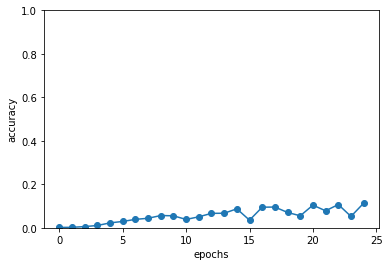

In [7]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

# seq2seq 개선 

- 학습 속도를 개선하는 두 가지 방법

## 입력 데이터 반전 (Reverse)

**입력 데이터의 순서를 반전시키면 학습 진행이 빨라져서, 결과적으로 정확도도 좋아진다고 함.**

와이?? - 기울기 전파가 원활해지기 때문 ( 타겟 단어와의 거리 차이가 줄어들어서 ) 

<img src ="../imgs/fig 7-23.png" width = "500" align = "center">

참고 문헌 : *Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. In Advances in neural information processing systems (pp. 3104-3112).*

#### 3.3 Reversing the Source Sentences

While the LSTM is capable of solving problems with long term dependencies, **we discovered that the LSTM learns much better when the source sentences are reversed (the target sentences are not reversed).** By doing so, the LSTM’s test perplexity dropped from 5.8 to 4.7, and the test BLEU scores of its decoded translations increased from 25.9 to 30.6.

**While we do not have a complete explanation to this phenomenon**, (저자들도 정확한 이유는 모름) **we believe that it is caused by the introduction of many short term dependencies to the dataset.** Normally, when we concatenate a source sentence with a target sentence, each word in the source sentence is far from its corresponding word in the target sentence. As a result, the problem has a large “minimal time lag” [17]. **By reversing the words in the source sentence, the average distance between corresponding words in the source and target language is unchanged. However, the first few words in the source language are now very close to the first few words in the target language, so the problem’s minimal time lag is greatly reduced.** Thus, backpropagation has an easier time “establishing communication” between the source sentence and the target sentence, which in turn results in substantially improved overall performance.

Initially, we believed that reversing the input sentences would only lead to more confident predictions in the early parts of the target sentence and to less confident predictions in the later parts. **However, LSTMs trained on reversed source sentences did much better on long sentences than LSTMs trained on the raw source sentences (see sec. 3.7), which suggests that reversing the input sentences results in LSTMs with better memory utilization.**

In [9]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data("addition.txt")
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id) # 13글자
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad  = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

reversed_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10 # 최초 10개만
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
        
    acc = float(correct_num) / len(x_test)
    reversed_acc_list.append(acc)
    print("검증 정확도 : %.3f%%" % (acc * 100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 2[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 3[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 3[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 4[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 5[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 5[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 7[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 7[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 8[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 8[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 9[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 10[s] | loss 1.73
Q   58+77
T 162 
☒ 100 
---
Q 461+579
T 1139
☒ 1000
---
Q  48+285
T 6

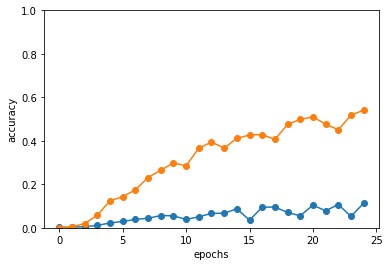

In [10]:
# 그래프 그리기
x = np.arange(len(acc_list))
graphs=[ acc_list, reversed_acc_list ] 

for g in graphs:
    plt.plot(x, g, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

## 엿보기(Peeky)

- Decoder는 Encoder에서의 h 만을 활용함
- 그만큼 h의 역할이 중요함. 
- but 현재는 Encoder의 최초 LSTM 만이 h를 이용. 더 활용하기 위한 방안.

<img src = "../imgs/fig 7-25.png" width = "700">

<img src = "../imgs/fig 7-26.png" width = "700">

- 기존에는 LSTM 한 계층에만 h를 전해줌
- 개선 후에는 모든 시각의 Affine 계층과 LSTM 계층에 Encoder의 출력 h를 전해준다. (엿본다)
- 1 ===> 8 